# Full SB2 Textbook Model

In [1]:
from os import path

import matplotlib.pyplot as plt
import numpy as np

from cobra import DictList

from mass import Simulation
from mass.io import json, sbml

model_dir = path.realpath(path.join("../SB2/models", "."))
model_names = ["Glycolysis", "PentosePhosphatePathway",
               "AMPSalvageNetwork", "Hemoglobin", "PFK"]

## Model Construction 

In [2]:
glycolysis, ppp, ampsn, hemoglobin, PFK = list(map(
    lambda x: json.load_json_model(model_dir + "/SB2_" + x + ".json"),
    model_names))

# Create merged model of glycolysis and the pentose phosphate pathway
textbook = glycolysis.merge(ppp, inplace=False)
# Add in AMP salvage network
textbook.merge(ampsn, inplace=True)
# Remove uncessesary exchanges
textbook.remove_reactions([
    r for r in textbook.boundary 
    if r.id in ["SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c",
                "DM_amp_c", "SK_amp_c", "SK_amp_c"]])

textbook.remove_boundary_conditions([
    met for met in textbook.boundary_conditions
    if met not in textbook.boundary_metabolites])
# Adjust stoichiometry and rate constant for PRPPS 
textbook.reactions.PRPPS.subtract_metabolites({
    textbook.metabolites.atp_c: -1,textbook.metabolites.adp_c: 2})
textbook.reactions.PRPPS.add_metabolites({
    textbook.metabolites.amp_c: 1})
# Add in hemoglobin module 
textbook.merge(hemoglobin, inplace=True)
textbook.id = "RBC"

Academic license - for non-commercial use only


Read LP format model from file /var/folders/36/g2np3l0d6t9dyr4rk3tvc8f80000gn/T/tmpqf9pkqvu.lp


Reading time = 0.00 seconds


: 20 rows, 44 columns, 122 nonzeros


Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


Ignoring reaction 'ATPM' since it already exists.


Ignoring reaction 'SK_pi_c' since it already exists.


Ignoring reaction 'SK_amp_c' since it already exists.


Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


## Steady State Determination

In [3]:
# Minspan paths
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])

# Define new order for reactions
new_metabolite_order = ["glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c","g3p_c", 
                        "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", 
                        "_6pgl_c", "_6pgc_c", "ru5p__D_c",  "xu5p__D_c", "r5p_c", 
                        "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c", 
                        "r1p_c", "prpp_c", "_23dpg_c","hb_c", "hb_1o2_c", "hb_2o2_c", 
                        "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c", 
                        "adp_c", "atp_c", "nadp_c", "nadph_c", "gthrd_c", "gthox_c", 
                        "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
if len(textbook.metabolites) == len(new_metabolite_order):
    textbook.metabolites = DictList(textbook.metabolites.get_by_any(new_metabolite_order))
# Define new order for metabolites
new_reaction_order = ["HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", 
                      "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE", 
                      "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", 
                      "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", "DPGM", 
                      "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM", 
                      "DM_nadh","GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c",
                      "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c","SK_pi_c", 
                      "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]
if len(textbook.reactions) == len(new_reaction_order):
    textbook.reactions = DictList(textbook.reactions.get_by_any(new_reaction_order))
    
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {textbook.reactions.SK_glc__D_c: 1.12, 
                      textbook.reactions.DM_nadh: 0.2*1.12, 
                      textbook.reactions.GSHR : 0.42, 
                      textbook.reactions.SK_ade_c: -0.014, 
                      textbook.reactions.ADA: 0.01,
                      textbook.reactions.SK_adn_c: -0.01, 
                      textbook.reactions.ADNK1: 0.12, 
                      textbook.reactions.SK_hxan_c: 0.097, 
                      textbook.reactions.DPGM: 0.441}

# Compute steady state fluxes
textbook.compute_steady_state_fluxes(minspan_paths, 
                                     independent_fluxes, 
                                     update_reactions=True);
ignore = [r.id for r in textbook.boundary] + ["HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ADK1"]
steady_state_fluxes = {rxn: flux for rxn, flux in textbook.steady_state_fluxes.items()
                       if rxn.id not in ignore}
# # Calculation of PERCs
textbook.calculate_PERCs(fluxes=steady_state_fluxes, update_reactions=True);
textbook.reactions.SK_o2_c.kf = 509726
textbook.reactions.HBDPG.kf =519613
textbook.reactions.HBO1.kf = 506935
textbook.reactions.HBO2.kf = 511077
textbook.reactions.HBO3.kf = 509243
textbook.reactions.HBO4.kf = 501595

## Steady State Validation

Successfully loaded MassModel 'RBC' into RoadRunner.


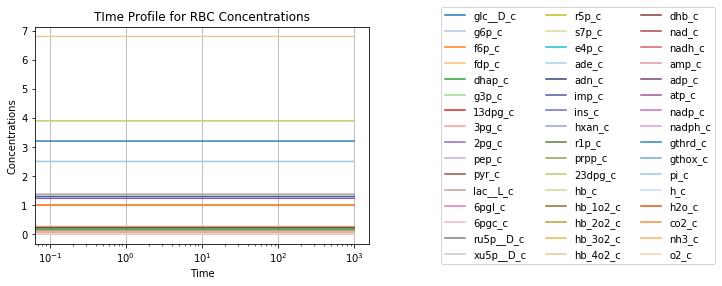

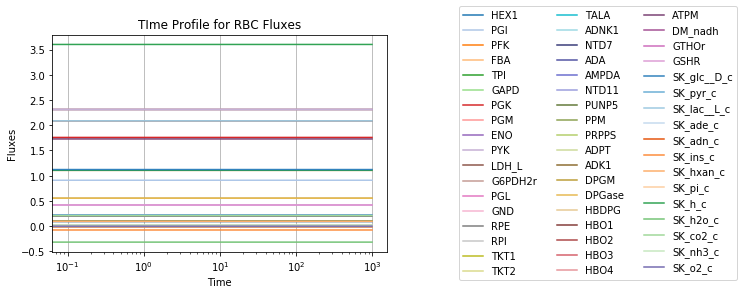

In [4]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(textbook, verbose=True)
sim.find_steady_state(textbook, strategy="nleq2", update_values=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol_list, flux_sol_list = sim.simulate(textbook, time=(0, 1e3, 1e4 + 1))
conc_sol, flux_sol = conc_sol_list[0], flux_sol_list[0]
# Quickly render and display time profiles 
for sol in [conc_sol, flux_sol]:
    sol.view_time_profile
    plt.show()

## Add PFK

In [5]:
textbook.remove_reactions([textbook.reactions.PFK])
textbook.merge(PFK, inplace=True)
textbook.id = "RBC_PFK"
# textbook.custom_parameters.update({"kf_PFK": 3.07e5, "kf_PFK_A": 1.25e5, "kf_PFK_F": 5.05e7})

## Steady State Validation

Successfully loaded MassModel 'RBC_PFK' into RoadRunner.


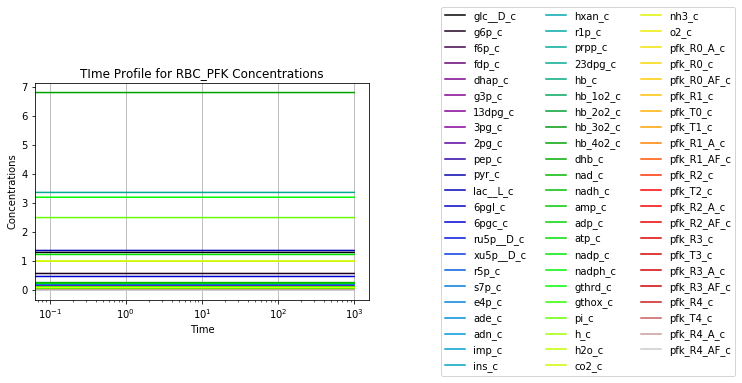

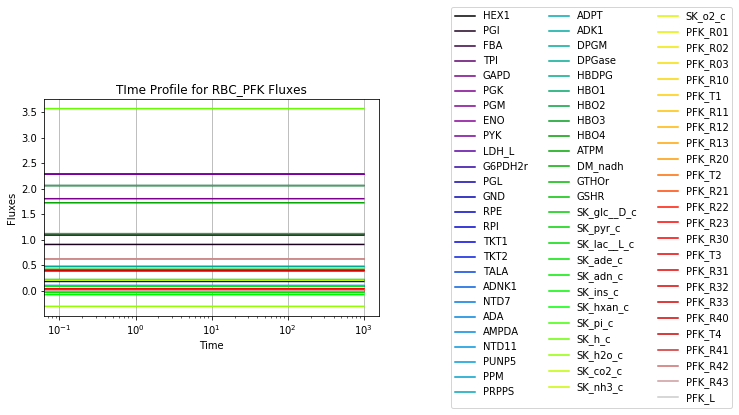

In [6]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(textbook, verbose=True)
sim.find_steady_state(textbook, strategy="nleq2", update_values=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol_list, flux_sol_list = sim.simulate(textbook, time=(0, 1e3, 1e4 + 1))
conc_sol, flux_sol = conc_sol_list[0], flux_sol_list[0]
# Quickly render and display time profiles 
for sol in [conc_sol, flux_sol]:
    sol.view_time_profile
    plt.show()

## Export

In [7]:
filepath = path.realpath(path.join("models", "SB2_Textbook"))

### Export using JSON

In [8]:
json.save_json_model(mass_model=textbook, filename=filepath + ".json")

### Export using SBML

In [9]:
sbml.write_sbml_model(mass_model=textbook, filename=filepath + ".xml")